# Waldemar Chang - Assignment 5: Constructing the Rectification and Interface Services
## EN.705.603.82.FA24 Creating AI-Enabled Systems
### Task 4
#### In a notebook called notebooks/hard_mining_analysis.ipynb, analyze the behavior of your hard negative mining strategy (e.g., ask yourself questions like "What kind of samples are considered 'hard' for the model?", "What kind of parameters greatly impact the behavior of your sampling results?", etc.)

In [1]:
import os
import gc
import torch
import random
import psutil
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from nms import filter
from object_detection import Model, draw_bboxes
from helper import calculate_iou, get_ground_truth
from hard_negative_mining import compute_yolo_loss, sample_hard_negatives, compute_difficulty_metric

In [2]:
# Define path to folder containing images and labels
#folder_path = r"C:\Users\walde\techtrack\notebooks\logistics"
folder_path = r"/teamspace/studios/this_studio/logistics"

# Initialize model
model = Model('model2.cfg', 'model2.weights')

# Get all image file names
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Sort the image files
image_files.sort()

# Select the first 50 images in the list
sampled_images = image_files[0:50]

Output layer names: ('yolo_30', 'yolo_37')


In [3]:
# Placeholder lists to store analysis results
losses = []
entropies = []
ious = []

# Number of classes
num_classes = 20
epsilon = 1e-7

# Loop through all sampled files in the directory
for file_name in sampled_images:
    try:
        print(f"\nProcessing {file_name}")
        if file_name.endswith('.jpg'):
            base_name = os.path.splitext(file_name)[0]
            print(f"Base name: {base_name}")
            
            text_file = os.path.join(folder_path, f"{base_name}.txt")
            print(f"Annotation file: {text_file}")
            
            if os.path.exists(text_file):
                print(f"Found annotation file for {file_name}")
                
                # Read the image
                image_path = os.path.join(folder_path, file_name)
                print(f"Image path: {image_path}")
                image = cv.imread(image_path)
                
                if image is None:
                    print(f"Skipping {file_name}: Image could not be loaded.")
                    continue
                
                # Use the model's preprocess method
                try:
                    preprocessed_image, original_image = model.preprocess(image)
                    print("Image preprocessed successfully")
                except Exception as e:
                    print(f"Error during preprocessing: {e}")
                    continue
                
                # Make predictions
                try:
                    print("Making predictions with the model...")
                    with torch.no_grad():
                        bboxes, class_ids, scores = model.predict(preprocessed_image)
                    print("Model predictions obtained")
                except Exception as e:
                    print(f"Error during model prediction: {e}")
                    continue
                
                # Check if predictions are None
                if bboxes is None or class_ids is None or scores is None:
                    print("Model returned None for predictions.")
                    continue
                
                # Post-process predictions to filter by score threshold
                filtered_bboxes, filtered_class_ids, filtered_scores = model.post_process(bboxes, class_ids, scores, original_image, score_threshold=0.5)
                
                # Prepare predictions without post-processing
                predictions = []
                if filtered_bboxes:
                    for idx_in_list in range(len(filtered_bboxes)):
                        bbox = filtered_bboxes[idx_in_list]
                        class_id = filtered_class_ids[idx_in_list]
                        score = filtered_scores[idx_in_list]
                        objectness = score
                        
                        # Create a one-hot encoded class_scores vector
                        class_scores = np.zeros(num_classes)
                        class_scores[class_id] = score
                        
                        # Normalize and clip to prevent issues
                        class_scores = np.clip(class_scores / (class_scores.sum() + epsilon), epsilon, 1.0)

                        print(f"Processing prediction {idx_in_list+1}/{len(filtered_bboxes)}")
                        predictions.append({
                            'bbox': bbox,
                            'class_scores': class_scores,  # Full class scores (one-hot encoded)
                            'label': class_id,
                            'objectness': objectness
                        })
                else:
                    print("No predictions.")
                    predictions = []
    
                # Load annotations
                ground_truth = get_ground_truth(text_file)
                annotations = [{'label': class_id, 'bbox': bbox} for class_id, bbox in ground_truth]
                print(f"Total annotations processed: {len(annotations)}")
                
                # Calculate loss between predictions and annotations
                try:
                    print("Calculating loss...")
                    loss = compute_yolo_loss(predictions, annotations, num_classes)
                    print(f"Loss calculated: {loss}")
                except Exception as e:
                    print(f"Error during loss computation: {e}")
                    continue
                losses.append(loss)
                
                # Calculate entropy-based difficulty metric
                if predictions:
                    try:
                        print("Calculating difficulty metric...")
                        entropy = compute_difficulty_metric(preprocessed_image, predictions)
                        print(f"Difficulty metric calculated: {entropy}")
                        entropies.append(entropy)
                    except Exception as e:
                        print(f"Error during difficulty metric computation: {e}")
                        continue
                else:
                    print("No predictions for difficulty metric.")
                    entropies.append(0.0)
                
                # Calculate IoU for analysis
                if predictions:
                    print("Calculating IoUs...")
                    for pred in predictions:
                        max_iou = 0
                        for ann in annotations:
                            iou = calculate_iou(pred['bbox'], ann['bbox'])
                            max_iou = max(max_iou, iou)
                        ious.append(max_iou)
                    print("IoUs calculated")
                else:
                    print("No predictions for IoU calculation.")
                    ious.append(0.0)
                    
            else:
                print(f"Annotation file not found for {file_name}")
    
        # Memory monitoring
        process = psutil.Process(os.getpid())
        memory_usage = process.memory_info().rss / (1024 * 1024)
        print(f"Memory usage after processing {file_name}: {memory_usage:.2f} MB")
    
        print(f"Finished processing of {file_name}")
        
        # Clean up variables
        del image, preprocessed_image, original_image
        del bboxes, class_ids, scores
        del predictions, annotations
        
        # Force garbage collection
        gc.collect()
        torch.cuda.empty_cache()  # Clear GPU cache if using GPU

    except Exception as e:
        print(f"An error occurred while processing {file_name}: {e}")
        continue


Processing -01-15-1-1-1-2-26_jpg.rf.eb62a0a5f84fcbdbc0910af072cf0072.jpg
Base name: -01-15-1-1-1-2-26_jpg.rf.eb62a0a5f84fcbdbc0910af072cf0072
Annotation file: /teamspace/studios/this_studio/logistics/-01-15-1-1-1-2-26_jpg.rf.eb62a0a5f84fcbdbc0910af072cf0072.txt
Found annotation file for -01-15-1-1-1-2-26_jpg.rf.eb62a0a5f84fcbdbc0910af072cf0072.jpg
Image path: /teamspace/studios/this_studio/logistics/-01-15-1-1-1-2-26_jpg.rf.eb62a0a5f84fcbdbc0910af072cf0072.jpg


Image preprocessed successfully
Making predictions with the model...
Inference time elapsed: 0.09 seconds
Model predictions obtained
Processing prediction 1/9
Processing prediction 2/9
Processing prediction 3/9
Processing prediction 4/9
Processing prediction 5/9
Processing prediction 6/9
Processing prediction 7/9
Processing prediction 8/9
Processing prediction 9/9
Total annotations processed: 11
Calculating loss...
Loss calculated: 2.189877912402153
Calculating difficulty metric...
Difficulty metric calculated: 0.000264394695477215
Calculating IoUs...
IoUs calculated
Memory usage after processing -01-15-1-1-1-2-26_jpg.rf.eb62a0a5f84fcbdbc0910af072cf0072.jpg: 560.21 MB
Finished processing of -01-15-1-1-1-2-26_jpg.rf.eb62a0a5f84fcbdbc0910af072cf0072.jpg

Processing -01-15-1-4-1-1-14_jpg.rf.2e89a06faa1c217b95a0e0d7177e8397.jpg
Base name: -01-15-1-4-1-1-14_jpg.rf.2e89a06faa1c217b95a0e0d7177e8397
Annotation file: /teamspace/studios/this_studio/logistics/-01-15-1-4-1-1-14_jpg.rf.2e89a06faa1c

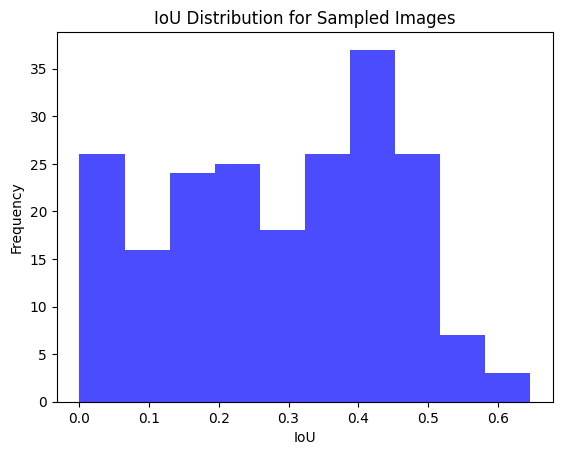

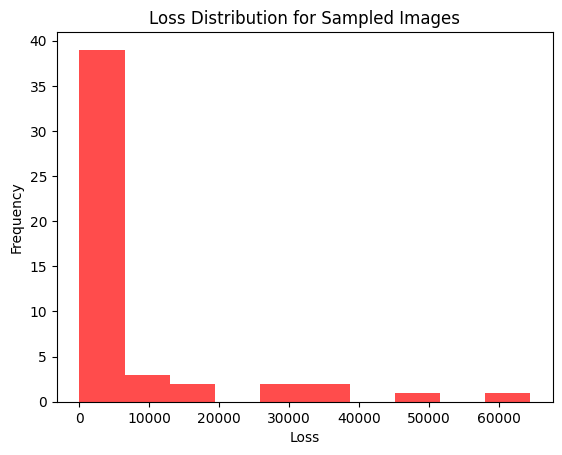

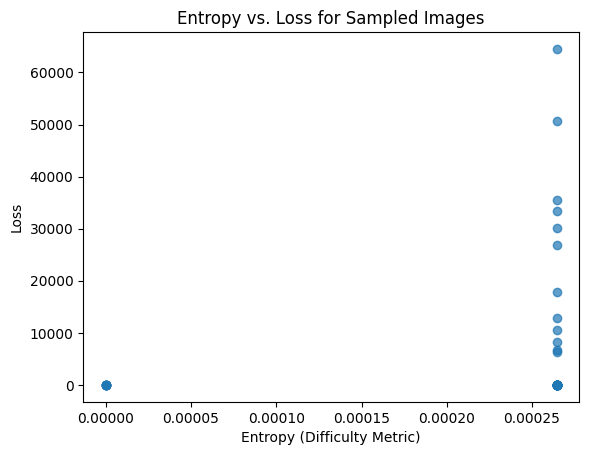

Mean Loss: 6070.12
Mean Entropy: 0.00
Mean IoU: 0.29


In [4]:
# Analysis Summary
# Plot distribution of IoU values for the sampled images
plt.hist(ious, bins=10, alpha=0.7, color='b')
plt.xlabel("IoU")
plt.ylabel("Frequency")
plt.title("IoU Distribution for Sampled Images")
plt.show()

# Plot distribution of losses
plt.hist(losses, bins=10, alpha=0.7, color='r')
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.title("Loss Distribution for Sampled Images")
plt.show()

# Scatter plot of Entropy vs Loss to see correlation
plt.scatter(entropies, losses, alpha=0.7)
plt.xlabel("Entropy (Difficulty Metric)")
plt.ylabel("Loss")
plt.title("Entropy vs. Loss for Sampled Images")
plt.show()

# Summary Statistics
mean_loss = np.mean(losses)
mean_entropy = np.mean(entropies)
mean_iou = np.mean(ious)

print(f"Mean Loss: {mean_loss:.2f}")
print(f"Mean Entropy: {mean_entropy:.2f}")
print(f"Mean IoU: {mean_iou:.2f}")

### Analysis

The hard negative mining strategy aims to improve the performance of a YOLO-based object detection model by focusing on difficult examples that the model struggles with. The provided visualizations and statistics offer a look into the effectiveness of this strategy, helping us understand the kinds of samples that are considered "hard" for the model and which parameters significantly impact the sampling process.

#### Observations from Visualizations
The IoU distribution shows that a majority of the samples have low IoU values, with very few samples achieving IoU above 0.5. This indicates that most of the predictions are not well-aligned with the ground truth, which is typical for hard negatives. These are cases where the model is failing to effectively localize objects, perhaps due to cluttered backgrounds, occlusions, or small object sizes. The mean loss of the sampled images is 6070.12, which indicates that the model encounters several challenging examples, with some predictions resulting in very high loss values. The loss distribution is heavily skewed, with most of the samples having relatively low losses, but a significant number having exceptionally high losses. These high-loss samples are precisely what the hard negative mining strategy targets. By focusing on these samples during training, the model can learn to correct its errors, thereby reducing the overall error rate and improving generalization.

The mean entropy is 0.00, which suggests that the model is extremely confident in its predictions, even for those that turn out to be incorrect. The scatter plot of entropy versus loss highlights an important trend: the model tends to be overconfident (low entropy) even when the loss is high. This suggests that the model is certain about its predictions, despite those predictions being incorrect. This behavior is problematic because it implies that the model does not effectively understand when it is uncertain, which limits its ability to learn effectively from mistakes. The mean IoU (Intersection over Union) value of 0.29 further highlights the model's struggle with accurate predictions. An IoU of 0.29 suggests that, on average, the predicted bounding boxes do not overlap significantly with the ground truth boxes, indicating that many of the model's predictions are either misplaced or incorrectly sized. This low average IoU also explains why the loss is relatively high for certain samples. The distribution of IoU values in the histogram shows a concentration of low values, which is indicative of the model's difficulty in accurately localizing objects, particularly for hard negative examples.

#### Key Factors Impacting Hard Negative Mining

The IoU threshold is a critical parameter that greatly influences which samples are considered "hard". In the provided compute_yolo_loss function, predictions with an IoU below 0.5 are treated as negatives, and their objectness score is penalized. Lowering this threshold would increase the number of samples considered as hard negatives, potentially improving the model's ability to learn from challenging cases but also increasing the risk of focusing on noise. The confidence score threshold in the post-processing step filters out predictions with low confidence. Adjusting this threshold can have a significant impact on the mining process. A higher threshold would reduce the number of false positives but might miss potential hard negatives that could contribute to the learning process. The weights used in the loss function, such as lambda_bb for bounding box loss and lambda_cls for classification loss, also play a role in determining the importance of different components of the loss. Increasing the weight for hard negatives (e.g., by increasing lambda_cls for incorrect classifications) can help the model focus more on difficult examples, potentially improving overall accuracy.

#### Addressing High Loss Values
The model appears to struggle with specific classes, such as cars, which may be contributing to the high losses. This could be due to underrepresentation of these classes in the training set. Addressing class imbalance through techniques like oversampling minority classes or using class-aware sampling strategies can help mitigate this issue. Some images might have conditions that are inherently difficult for the model to handle, such as occlusions, cluttered backgrounds, or small object sizes, making the predictions inaccurate. This can significantly increase the loss, especially for bounding box predictions. The low entropy values indicate that the model is often overconfident in its predictions, even when incorrect. This overconfidence can exacerbate the loss, particularly when the predicted classes are wrong but have high confidence scores. Techniques like label smoothing can help reduce this overconfidence.

High losses may also be due to poor alignment between predicted bounding boxes and ground truth annotations, as suggested by low IoU values. If the bounding box prediction is far from the true location, both the localization loss and objectness loss will be high. The weights (lambda_bb, lambda_obj, etc.) in the loss function can also amplify certain aspects of the loss calculation, particularly for bounding box or objectness loss. This could be leading to very high losses for samples where the model's predictions are far from accurate. In the specific case of the images where high losses (e.g., 64513.54) were reported, it is likely that the model's predicted bounding boxes were significantly misaligned with the ground truth, resulting in a high localization loss. Additionally, the classification confidence was likely very high for an incorrect class, leading to a large contribution from the classification loss. Many of these high-loss cases seem to be associated with images of cars, which might indicate specific challenges related to the car class, such as varied poses, occlusions, or reflective surfaces. These factors combined could explain why the loss for those particular samples was so extreme.